# Task 3: Transfer Learning

In [25]:
import importlib
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import src.loading as loading
import src.models as models

importlib.reload(loading)
importlib.reload(models)

<module 'src.models' from 'c:\\Users\\seppe\\AI project\\AI-project\\notebooks\\src\\models.py'>

## 1. Set up the classification

In [12]:
# Choose a metric to evaluate the succes of the classifier.
metrics=['accuracy']

In [13]:
# Set a seed for NumPy and Keras for preproducibility.
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
# Set up image generators for the training, validation, and test data.
img_height, img_width = 128, 128
batch_size = 32
path = "../data"
train_data_gen, val_data_gen, train_and_val_data_gen, test_data_gen = loading.get_images(path, img_height, img_width, batch_size, norm="training", color_mode="rgb")

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


## 2. Setup the base model

In [15]:
# Instantiate the base model with the "imagenet" pre-trained weights, not including the top layers.
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

In [16]:
# Freeze all layers in the base model.
base_model.trainable = False

In [25]:
# Add fully connected layers to the base model for the classification task.
model = models.transfer_model(
    base_model,
    dropout_rate = 0.2,
    dense_unit = 256,
    lr =0.001,
    metrics=metrics)

In [26]:
# Print the final architecture.
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,953,921 (121.89 MB)

 Trainable params: 8,389,121 (32.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

## 3. Training the model

In [17]:
total_train = train_data_gen.samples
total_val = val_data_gen.samples

print(f"total_train: {total_train}")
print(f"total_val: {total_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train // batch_size}")

total_train: 1600
total_val: 400
batch_size: 32
steps_per_epoch: 50


In [28]:
# Training the model.
epochs = 30

history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 560ms/step - accuracy: 0.6994 - loss: 8.4514 - val_accuracy: 0.7552 - val_loss: 0.5244
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 508ms/step - accuracy: 0.9103 - loss: 0.2348 - val_accuracy: 0.8307 - val_loss: 0.4130
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 506ms/step - accuracy: 0.9482 - loss: 0.1396 - val_accuracy: 0.8203 - val_loss: 0.4713
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 506ms/step - accuracy: 0.9592 - loss: 0.1043 - val_accuracy: 0.8333 - val_loss: 0.4009
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 508ms/step - accuracy: 0.9809 - loss: 0.0689 - val_accuracy: 0.8073 - val_loss: 0.4226
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 514ms/step - accuracy: 0.9883 - loss: 0.0476 - val_accuracy: 0.8516 - val_loss: 0.4769
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 507ms/step - accuracy: 0.9868 - loss: 0.0465 - val_accuracy: 0.8359 - val_loss: 0.4843
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 514ms/step - accuracy: 0.9925 - loss: 0.0300 - val_accu

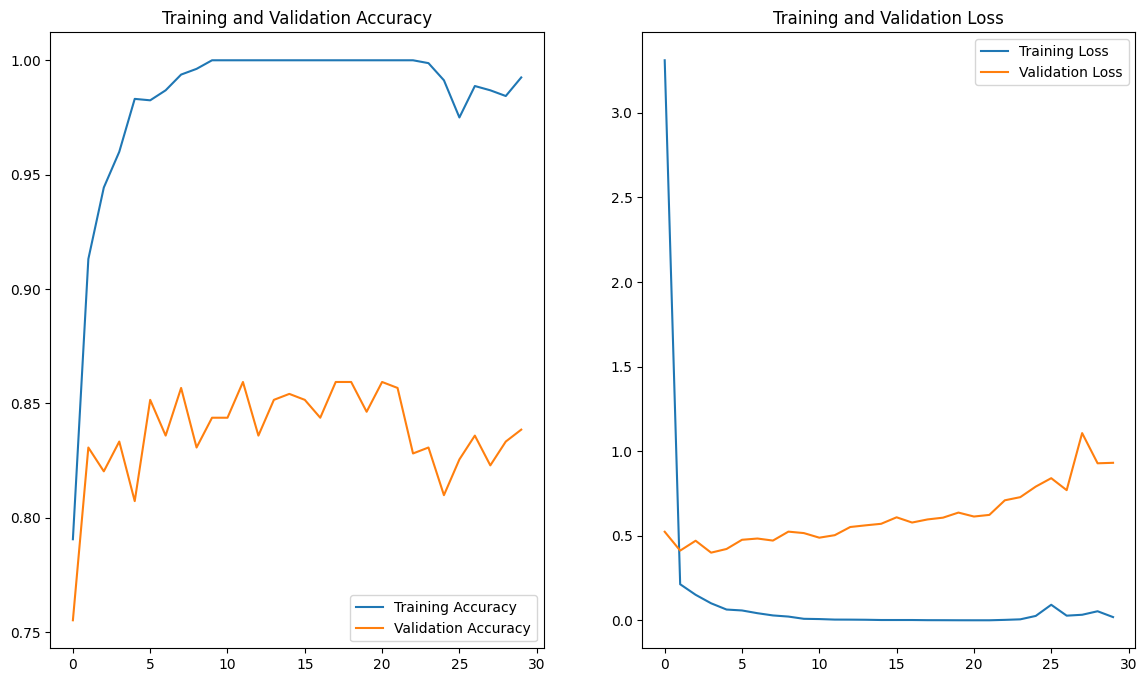

In [29]:
# Plot the model history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 4. Hyperparameter tuning

In [18]:
# Implement the Keras EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [19]:
# Hyperparameter options.
batch_sizes = [64, 32]
learning_rates = [0.001, 0.0005]
dropout_rates = [0.1, 0.2, 0.3]

# Create hyperparameter grid.
hyperparameter_grid = list(product(batch_sizes, learning_rates, dropout_rates))

In [20]:
# Rough parameter search.
epochs = 30

total_iterations = len(hyperparameter_grid)
results = []  # List to store results from each run.

print(f"Total iterations: {total_iterations}")

for idx, (batch_size, lr, dropout_rate) in enumerate(hyperparameter_grid):
    print(f"\nRunning: batch_size={batch_size}, learning_rate={lr}, dropout_rate={dropout_rate}")
    
    # Build the model with the current hyperparameters.
    model = models.transfer_model(
    base_model,
    dropout_rate=dropout_rate,
    dense_unit=256,
    lr=lr,
    metrics=metrics)
    
    # Train the model.
    history = model.fit(
        train_data_gen,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size,
        callbacks=[early_stop],
        verbose=0  # Reduce training output during tuning.
    )
    
    # Find the best validation accuracy and the corresponding epoch.
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    final_val_loss = history.history['val_loss'][best_epoch - 1]
    
    # Append hyperparameters and performance metrics to the results.
    results.append({
        'batch_size': batch_size,
        'learning_rate': lr,
        'dropout_rate': dropout_rate,
        'best_val_accuracy': best_val_acc,
        'best_epoch': best_epoch,
        'final_val_loss': final_val_loss 
    })
    print(f"Completed: best_val_accuracy={best_val_acc:.4f} at epoch {best_epoch}")

    print(idx + 1, "/", total_iterations, end="\r")  # Print progress.

# Move to a new line after the progress bar.
print("\nHyperparameter tuning complete.")

Total iterations: 12

Running: batch_size=64, learning_rate=0.001, dropout_rate=0.1
Completed: best_val_accuracy=0.9635 at epoch 2
1 / 12
Running: batch_size=64, learning_rate=0.001, dropout_rate=0.2
Completed: best_val_accuracy=0.8594 at epoch 5
2 / 12
Running: batch_size=64, learning_rate=0.001, dropout_rate=0.3
Completed: best_val_accuracy=0.8333 at epoch 2
3 / 12
Running: batch_size=64, learning_rate=0.0005, dropout_rate=0.1
Completed: best_val_accuracy=0.9115 at epoch 6
4 / 12
Running: batch_size=64, learning_rate=0.0005, dropout_rate=0.2
Completed: best_val_accuracy=0.8802 at epoch 4
5 / 12
Running: batch_size=64, learning_rate=0.0005, dropout_rate=0.3
Completed: best_val_accuracy=0.9219 at epoch 6
6 / 12
Running: batch_size=32, learning_rate=0.001, dropout_rate=0.1
Completed: best_val_accuracy=0.8464 at epoch 3
7 / 12
Running: batch_size=32, learning_rate=0.001, dropout_rate=0.2
Completed: best_val_accuracy=0.8542 at epoch 5
8 / 12
Running: batch_size=32, learning_rate=0.001, dr

In [21]:
# Create a DataFrame from the results and save to CSV.
df_results = pd.DataFrame(results)
csv_filename = "../results/hyperparameter_tuning_results_transfer.csv"
df_results.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

Results saved to ../results/hyperparameter_tuning_results_transfer.csv


## 5. Train pre-trained model

In [22]:
# Select the best configuration based on highest validation accuracy.
results_csv = "../results/hyperparameter_tuning_results_transfer.csv"
df_results = pd.read_csv(results_csv)

best_config = df_results.sort_values('best_val_accuracy', ascending=False).iloc[0]
best_batch_size = int(best_config['batch_size'])
best_lr = best_config['learning_rate']
best_dropout = best_config['dropout_rate']

print("Best Hyperparameters:")
print(best_config)

Best Hyperparameters:
batch_size           64.000000
learning_rate         0.001000
dropout_rate          0.100000
best_val_accuracy     0.963542
best_epoch            2.000000
final_val_loss        0.139353
Name: 0, dtype: float64


In [50]:
# Final model
best_model = models.transfer_model(
    base_model,
    dropout_rate=best_dropout,
    dense_unit=256,
    lr=best_lr,
    metrics=metrics)

best_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,953,921 (121.89 MB)

 Trainable params: 8,389,121 (32.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [51]:
total_train_and_val = train_and_val_data_gen.samples

print(f"total_train_and_val: {total_train_and_val}")
print(f"batch_size: {best_batch_size}")
print(f"steps_per_epoch: {total_train_and_val // best_batch_size}")

total_train_and_val: 2000
batch_size: 64
steps_per_epoch: 31


In [52]:
# Retraining the model using the complete training dataset (including the validation dataset).
epochs_full = 2  # Adjust this as needed.

history_full = best_model.fit(
    train_and_val_data_gen,
    batch_size=best_batch_size,
    steps_per_epoch=total_train_and_val // best_batch_size,
    epochs=epochs_full,
)

Epoch 1/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step - accuracy: 0.7186 - loss: 6.9126
Epoch 2/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.8149 - loss: 1.4500


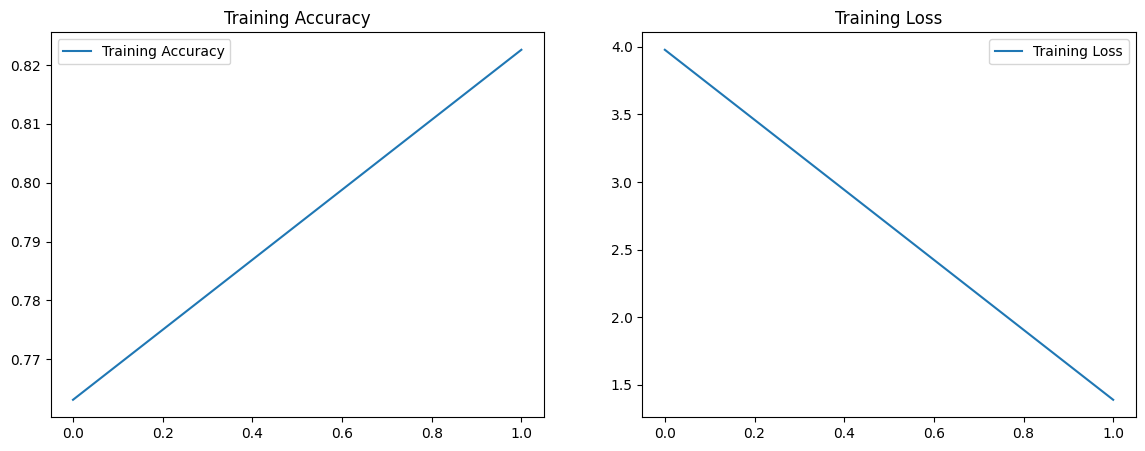

In [53]:
# Retrieve only the training history.
acc = history_full.history['accuracy']
loss = history_full.history['loss']
epochs_range = range(epochs_full)

# Plot only the training curves.
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [54]:
# Save the retrained model to disk.
model_save_path = "../results/final_transfer.keras"

best_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to ../results/final_transfer.keras


In [55]:
# Reload the model from disk.
reloaded_model = load_model(model_save_path)
print("Model loaded from disk.")

Model loaded from disk.


In [56]:
total_test = test_data_gen.samples
steps_test = total_test // best_batch_size

print(f"total_test: {total_test}")
print(f"steps_test: {steps_test}")

total_test: 200
steps_test: 3


In [57]:
# Evaluate the reloaded model on the test set.
test_loss, test_accuracy = reloaded_model.evaluate(
    test_data_gen, 
    steps=steps_test,
    verbose=1,
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.8854 - loss: 1.3996
Test Loss: 0.9846
Test Accuracy: 0.8958


In [58]:
# Generate predictions on the entire test set.
predictions = reloaded_model.predict(
    test_data_gen, 
    verbose=1
)

# For binary classification, use a threshold of 0.5.
predictions_class = (predictions > 0.5).astype(int).flatten()

# Get ground truth labels from the generator.
true_labels = test_data_gen.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 499ms/step


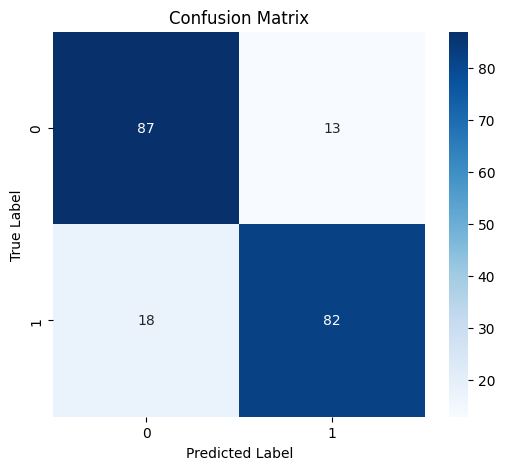

In [59]:
# Compute the confusion matrix.
cm = confusion_matrix(true_labels, predictions_class)

# Plot the confusion matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


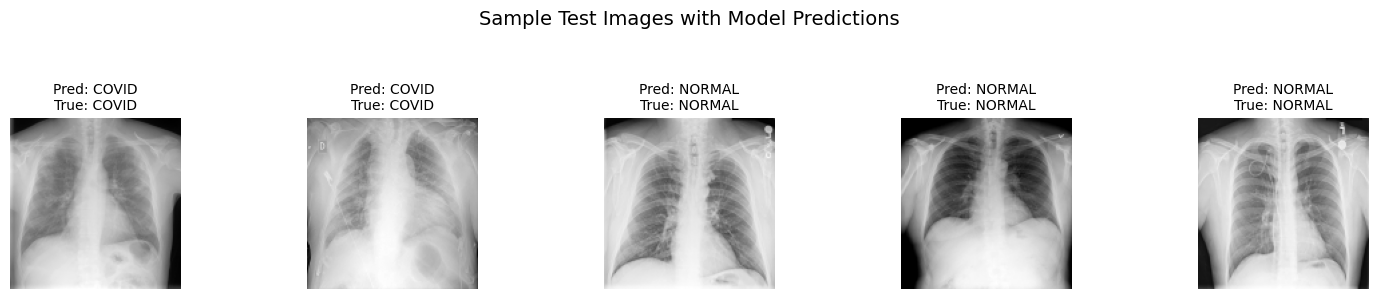

In [60]:
# Create a test data generator WITHOUT normalization (for displaying original images).
_, _, _, test_data_gen_no_norm = loading.get_images(
    path, 
    img_height, 
    img_width, 
    batch_size)

images, _, labels = loading.generator_to_array(test_data_gen_no_norm)

# Plot a few sample images with the predicted labels.
num_images_to_plot = 5
images_to_plot = random.sample(range(total_test), num_images_to_plot)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(images_to_plot):
    plt.subplot(1, num_images_to_plot, i+1)
    # Display the original (non-normalized) image.
    plt.imshow(images[idx].astype("uint8"), cmap="gray")
    
    true_label = labels[idx]
    pred_label = test_data_gen.class_names[predictions_class[idx]]
    
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
    plt.axis('off')
plt.suptitle("Sample Test Images with Model Predictions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.85])  # Leave space for suptitle
plt.show()

# Fine-tuning the entire model

In [ ]:
#unfreeze the base model

# Base model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = True

# Create the model
model = Sequential()
model.add(base_model)




model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000500)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

model.summary()



In [ ]:
#Train the model

epochs = 30

history = model.fit(
    train_and_val_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

In [ ]:
#Save the model in a different file and reload it

# Define the path where the model will be saved.
model_save_path = "../results/final2_transfer_learning.keras"

# Save the retrained model to disk.
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

In [ ]:
#Test the modal on the testdata

test_loss, test_accuracy = model.evaluate(
    test_data_gen, 
    steps=steps_test,
    verbose=1,
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
#confussion matrix

# Generate predictions on the entire test set.
predictions = reloaded_model.predict(
    test_data_gen, 
    verbose=1
)

# For binary classification, use a threshold of 0.5.
predictions_class = (predictions > 0.5).astype(int).flatten()

# Get ground truth labels from the generator.
true_labels = test_data_gen.classes

# Create a confusion matrix.
cm = confusion_matrix(true_labels, predictions_class)

# Plot the confusion matrix.
# Plot the confusion matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()   


In [ ]:
#samples from the testdata with and without pre-processing (with their evaluations)

#without pre-processing

#with pre-processing